In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#SUBWORDS
  * Burada bir kelimenin parçalandığında içindeki anlamlı olan kelimeleri teşhis edecez

##1-İMPORTİNG LİBRARİES

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences



##2-Get The Dataset

In [3]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
    -O /tmp/sentiment.csv

--2023-03-08 01:13:43--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 172.253.118.138, 172.253.118.100, 172.253.118.101, ...
Connecting to drive.google.com (drive.google.com)|172.253.118.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5vp8415kqgarit8pl9tjeavjv4ubo6p0/1678238025000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=502bb8e6-3a5e-4e24-93f0-21886abb3983 [following]
--2023-03-08 01:13:45--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5vp8415kqgarit8pl9tjeavjv4ubo6p0/1678238025000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=502bb8e6-3a5e-4e24-93f0-21886abb3983
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 74.125.68.132, 2404:6800:4003:c02::84
Connecting to doc

In [4]:
dataset = pd.read_csv('/tmp/sentiment.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

##3-CREATE A SUBWORDS DATASET
  * ALT KELİMELER İÇİN tensorlow_dataset içerisindeki SubwordTextEncoder kullanılacak
  * 1000 kelimeye sayı verilecek
  * Bir kelimenin içinde en fazla 5 adet alt kelime aranacak
  * Çok büyük veriler için uygulanabilir

In [5]:
# import libraries
import tensorflow_datasets as tfds

vocab_size = 1000

# create instance
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences,vocab_size,max_subword_length=5)

In [6]:
#çalışıp çalışmadığını kontrol edelim(6.cümle üzerinde çalışalım)
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

#Kodu çözülmüş her bir ayrı alt kelimeyi ayrı ayrı yazdıralım
for i in encoded:
  print(tokenizer.decode([i]))

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


##4-Let's code all our sentences

In [7]:
for i , sentence in enumerate(sentences):
   sentences[i] = tokenizer.encode(sentence)


In [8]:
print(sentences[1])

[625, 677, 626, 274, 380, 633, 148, 844, 789]


##5-Let's do Padding and Truncate operations




In [9]:
max_length = 50
trunc_type='post'
padding_type='post'

sentences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

##6-Train And Test processing

In [10]:
training_size = int(len(sentences) * 0.8)


training_sentences = sentences_padded[0:training_size]
testing_sentences = sentences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# sonrası için
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

##7-Create The model

In [11]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sentences, training_labels_final, epochs=num_epochs, 
                    validation_data=(testing_sentences, testing_labels_final))

##8-Visualize

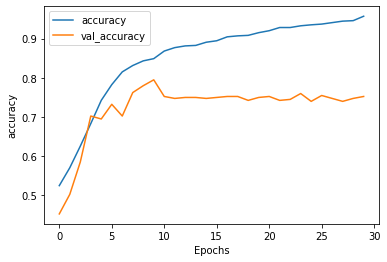

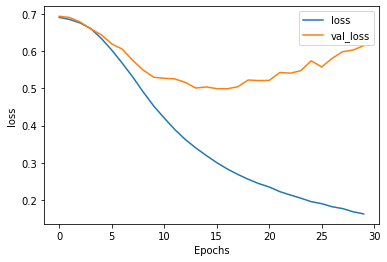

In [13]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

##9-Get files for visualizing the network
  * http://projector.tensorflow.org/

In [ ]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

In [ ]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(0, vocab_size - 1):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')